# TP : Essaims de nano-satellites
Ce TP a pour objectif de vous familiariser davantage avec les topologies d'essaims de nano-satellites en exploitant un jeu de données. Vous verrez notamment qu'on peut extraire énormément d'informations à partir d'un jeu de données simple (ici, positions des satellites par pas de temps). Le TP se déroule en 4 parties :
***
1. Chargement des données : découverte du jeu de données et formattage pour la suite
2. Visualisation de la topologie
3. Caractérisation du réseau : calcul de métriques
4. Partage de charge : division en sous-réseaux
***

Nous allons d'abord importer les librairies nécessaires, dont le module de simulation `swarm_sim` disponible dans le dossier `tp`.

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from swarm_sim import *

## 1. Chargement des données
Les données sont stockées dans le dossier `data` du repository Git, et sont réparties en 100 traces de nano-satellites sur 10000 échantillons.

Ouvrez une trace en exécutant la cellule suivante, et rappelez les champs ainsi que les unités utilisées (n'hésitez pas à revoir le cours, slide 20).

In [3]:
PATH = '..\data\Traces_Nanosatellites\\track_0.csv'

df = pd.read_csv(PATH, sep=',', header=0)
df['coords'] = ['x','y','z']
df = df.set_index('coords', drop=True)

df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


Chargez la totalité des données dans ce notebook. Le plus simple est de créer un dictionnaire contenant ces données suivant ce format : 

`satellites[id] = track`

Modifiez les variables `iter_max` et `PATH` si nécessaire.

*NB : le chargement peut être assez long (plusieurs minutes en fonction de la machine). Vous pouvez visualiser la progression du chargement avec la fonction `tqdm()` qui fonctionne comme suit :*

In [4]:
NB_NODES = 100
PATH = '..\data\Traces_Nanosatellites\\track_'

satellites = {}

with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df = pd.read_csv(PATH+str(i)+'.csv', sep=',', header=0)
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)
    

satellites[0].head()

Extracting data:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting data: 100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


Convertissez les données en objets `Swarm` tel que définis dans le module `swarm_sim` (lire la doc pour le formattage).

Afin de faciliter la suite du traitement, nous allons créer un objet `Swarm` par pas de temps et les stocker dans un dictionnaire tel que :

`dict_swarm[timestamp] = Swarm`

*NB : le formattage peut également prendre un peu de temps en fonction de la quantité de données à formatter. N'hésitez pas à utiliser la fonction `tqdm()` décrite plus haut si vous le souhaitez.*

In [5]:
help(Swarm.__init__)

Help on function __init__ in module swarm_sim:

__init__(self, connection_range=0, nodes=[])
    Swarm object constructor
    
    Args:
        connection_range (int, optional): the maximum distance between two nodes to establish a connection. Defaults to 0.
        nodes (list, optional): list of Node objects within the swarm. Defaults to [].



In [6]:
CONNECTION_RANGE = 30000 # Nous allons travailler avec une portée de communication fixe de 30 km
DURATION = 10000 # Nombre d'échantillons temporels à analyser


dict_swarm = {}

with tqdm(total=DURATION, desc='Converting to Swarm') as pbar:
    for t in range(DURATION):
        dict_swarm[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
        )
        pbar.update(1)

Converting to Swarm: 100%|██████████| 10000/10000 [01:16<00:00, 130.23it/s]


Affichez le contenu du `dict_swarm` à l'instant `0`, ainsi que la description d'un noeud de votre choix. Assurez-vous de bien comprendre tous les champs affichés.

In [7]:
swarm = dict_swarm[0]

print(swarm)
print(swarm.nodes[0])

Swarm of 100 node(s), connection range: 30000
Node ID 0 (-485074.7,-706653.0,-2026363.5) has 0 neighbor(s)	Group: -1


## 2. Visualisation de la topologie
Le module `swarm_sim` permet notamment de créer des graphiques 3D représentant les positions des satellites à un instant donné, avec si besoin les ISL (liens inter-satellites) existants. Il s'agit des fonctions `plot_nodes()` et `plot_edges()`.

Affichez la topologie de l'essaim à un pas de temps donné, puis à un autre. 

Qu'observez-vous au niveau de la topologie ?

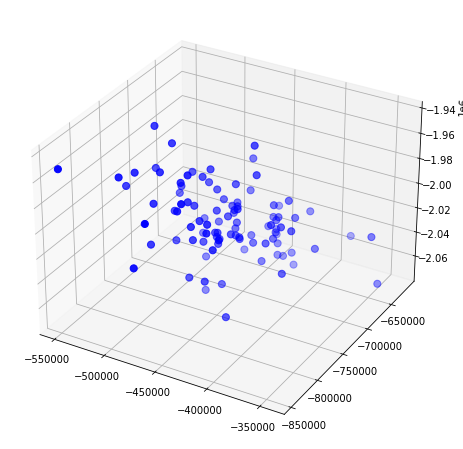

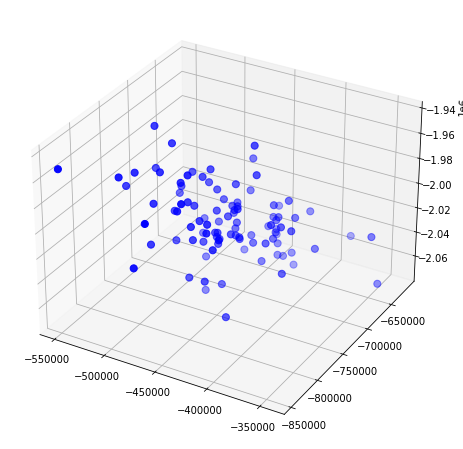

In [9]:
dict_swarm[0].plot_nodes()
dict_swarm[0].plot_edges()

Vous avez sûrement remarqué que la fonction `plot_edges()` ne fonctionne pas, ou du moins elle n'affiche aucune connexion dans l'essaim. Pourquoi ?

In [ ]:
""" 
Réponse
"""

Etablissez les connexions entre noeuds voisins grâce à la fonction `neighbor_matrix()` (regardez la doc), puis affichez la topologie de l'essaim grâce à la fonction `plot_edges()`.

In [10]:
help(Swarm.neighbor_matrix)

Help on function neighbor_matrix in module swarm_sim:

neighbor_matrix(self, connection_range=None)
    Function to compute the neighbor matrix of the swarm.
    If two nodes are neighbors (according to the given connection range), the row[col] equals to 1. Else 0.
    
    Args:
        connection_range (int, optional): the connection range of the swarm. Defaults to None.
    
    Returns:
        list(list(int)): the 2-dimensional neighbor matrix formatted as matrix[node1][node2] = neighbor.



In [11]:
with tqdm(total=DURATION, desc='Neighbor matrix') as pbar:
    for t in range(DURATION):
        neighbor_matrix = dict_swarm[t].neighbor_matrix()
        pbar.update(1)

Neighbor matrix: 100%|██████████| 10000/10000 [01:18<00:00, 126.61it/s]


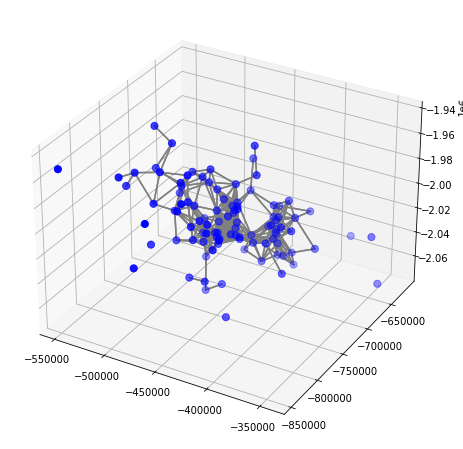

In [12]:
dict_swarm[0].plot_edges()

## 3. Caractérisation du réseau
Nous allons maintenant déterminer les caractéristiques du réseau en calculant certaines métriques. Cette caractérisation permet de comprendre plus en détail les différentes dynamiques dans l'essaim, et mettre en avant différents modèles de mobilité. 

La métrique la plus simple est le degré, soit le nombre de voisins directs d'un noeud. Calculez le degré moyen de l'essaim à l'instant `0` (faites bien attention au format des données renvoyées par la fonction `degree`), puis affichez l'évolution de ce degré moyen sur une révolution complète. Vérifiez que vous avez bien établi la connexion sur une révolution complète avant !

In [13]:
help(Swarm.degree)

Help on function degree in module swarm_sim:

degree(self)
    Function to compute the degree (aka the number of neighbors) of each node within the swarm.
    
    Returns:
        list(int): the list of node degrees.



In [14]:
REVOLUTION = 1800

# 1. Analyse du degré à l'instant 0
swarm = dict_swarm[0]
avg_degree = np.mean(swarm.degree())
print(avg_degree)

8.54


In [22]:
# 2. Analyse du degré moyen sur une révolution
avg_degrees = []

for t in range(REVOLUTION):
    avg_degrees.append(np.mean(dict_swarm[t].degree()))
        

#NB: il est plus propre, en Python, d'écrire cette fonction comme suit :
#avg_degrees = [np.mean(swarm.degree()) for swarm in dict_swarm.values()] 


Text(0, 0.5, 'Degré moyen')

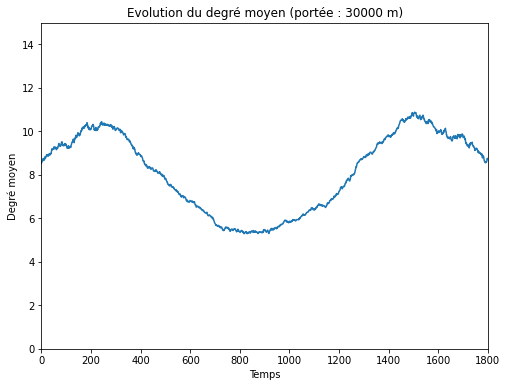

In [30]:
fig = plt.figure(figsize=(8,6))

idx = np.arange(len(avg_degrees))
plt.plot(idx, avg_degrees)

plt.title('Evolution du degré moyen (portée : '+str(CONNECTION_RANGE)+' m)')
plt.xlim(0,REVOLUTION)
plt.ylim(0,15)
plt.xlabel('Temps')
plt.ylabel('Degré moyen')

De la même façon, vous pouvez à présent calculer et regarder l'évolution de la k-vicinity, c'est-à-dire le voisinnage étendu à k sauts, de l'essaim. La fonction correspondante est `k_vicinity()`, attention au format des données renvoyées. Calculez la k-vicinity pour k = {1,2,3}.

In [31]:
help(Swarm.k_vicinity)

Help on function k_vicinity in module swarm_sim:

k_vicinity(self, depth=1)
    Function to compute the k-vicinity (aka the extended neighborhood) of each node in the swarm.
    The k-vicinity corresponds to the number of direct and undirect neighbors within at most k hops from the node.
    
    Args:
        depth (int, optional): the number of hops for extension. Defaults to 1.
    
    Returns:
        list(int): list of k-vicinity values for each node.



In [33]:
depth_search = [1,2,3]
avg_kvicinities = {}

for k in depth_search:
    avg_kvicinities[k] = [np.mean(dict_swarm[t].k_vicinity(depth=k)) for t in range(REVOLUTION)]

(0.0, 1800.0)

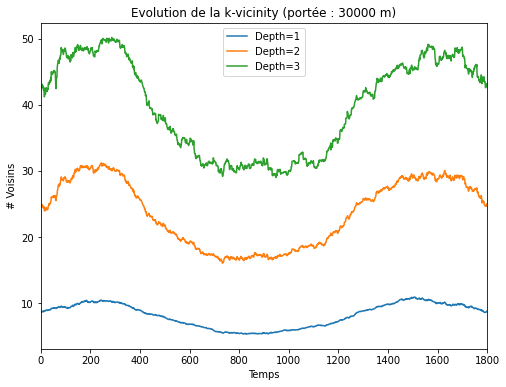

In [36]:
fig = plt.figure(figsize=(8,6))

for k, kvicinity in avg_kvicinities.items():
    plt.plot(kvicinity, label='Depth='+str(k))

plt.legend()
plt.title('Evolution de la k-vicinity (portée : '+str(CONNECTION_RANGE)+' m)')
plt.xlabel('Temps')
plt.ylabel('# Voisins')
plt.xlim(0,REVOLUTION)

Que pouvez-vous conclure sur le comportement de la connectivité (directe et indirecte) du réseau dans le temps ?

In [ ]:
""" 
Réponse
"""

## 4. Partage de charge sur le réseau
Nous allons maintenant nous intéresser à la gestion de la redondance et du recouvrement dans le réseau (slides 26+ du cours).

Considérons une mission d'interférométrie pour laquelle nous déployons l'essaim de 100 nanosatellites défini par nos données. Lors de la phase d'observation, i.e. lorsque la Lune bloque la quasi totalité des interférences radio terrestres, chaque nanosatellite va collecter près de 5 Gb de données brutes de l'espace. Afin de créer l'image globale collectée par l'essaim, toutes les données collectées doivent être échangées entre l'intégralité des satellites. Sans politique de limitation de recouvrement, le réseau va saturer très vite.

Afin de limiter ce recouvrement, une solution possible est de diviser le réseau en plusieurs sous-réseaux grâce à des algorithmes de division de graphe **(Graph Division)**. En effet, les sous-réseaux obtenus vont faire office de "noeuds" dans le graphe simplifié, et on va ainsi limiter la quantité de données échangées simultanément. Nous allons analyser les performances de trois algorithmes: **Random Node Division (RND)**, **Multi-Dimensional Random Walk (MDRW)** et **Forest Fire Division (FFD)**.

Cherchez les fonctions correspondantes à ces algorithmes dans la doc, et assurez-vous de bien comprendre leur principe de fonctionnement. Quelles sont les différences majeures dans leur implémentation ? 

In [ ]:
""" 
Réponse
"""

Prenez un essaim à un instant T et appliquez-lui d'abord l'algorithme `RND`. Paramétrez-le de sorte à obtenir `5` groupes.

In [ ]:
help(Swarm.RND)

In [ ]:
T = 0
swarm = dict_swarm[T]

swarm.reset_connection() # Bonne pratique avant de commencer : on remet tous les groupes à leur valeur par défaut (-1)
swarms_rnd = swarm.RND()

for i,sw in swarms_rnd.items():
    print(sw)
    print([n.id for n in sw.nodes])

Faites maintenant la même chose mais avec l'algorithme `MDRW` afin d'obtenir une autre répartition.

In [ ]:
help(Swarm.MDRW)

In [ ]:
swarm.reset_groups()
swarms_mdrw = swarm.MDRW()

for i,sw in swarms_mdrw.items():
    print(sw)
    print([n.id for n in sw.nodes])

Enfin, obtenez une troisième répartition grâce à l'algorithme `FFD`.

In [ ]:
help(Swarm.FFD)

In [ ]:
swarm.reset_groups()
swarms_ffd = swarm.FFD()

for i,sw in swarms_ffd.items():
    print(sw)
    print([n.id for n in sw.nodes])

A présent, nous allons comparer ces algorithmes en fonction de la répartition de la taille des groupes obtenus, l'idéal étant d'obtenir la répartition la plus homogène possible.

Exécutez les cellules suivantes afin de générer les graphiques correspondant aux répartitions des trois algorithmes. Adaptez le nom des variables si besoin.

In [ ]:
distrib_rnd = [len(sw.nodes) for sw in swarms_rnd.values()] # Distribution du nombre de noeuds par groupe
distrib_mdrw = [len(sw.nodes) for sw in swarms_mdrw.values()]
distrib_ffd = [len(sw.nodes) for sw in swarms_ffd.values()]

values = [] # Variable utilisée pour comparer les trois distributions sur la même échelle
values.extend(distrib_rnd)
values.extend(distrib_mdrw)
values.extend(distrib_ffd)

In [ ]:
labels = sorted(set(values))
x_pos = np.arange(min(labels), max(labels)+1)
data_rnd, data_mdrw, data_ffd = [], [], []
for k in x_pos:
       a,b,c = 0,0,0
       if k in distrib_rnd:
            a = len([e for e in distrib_rnd if e==k])
       data_rnd.append(a)
       if k in distrib_mdrw:
            b = len([e for e in distrib_mdrw if e==k])
       data_mdrw.append(b)
       if k in distrib_ffd:
            c = len([e for e in distrib_ffd if e==k])
       data_ffd.append(c)

# Création des histogrammes pour la comparaison 
fig, axes = plt.subplots(nrows=3, figsize=(6,12))
ax = axes[0] # Histogramme RND
ax.bar(x_pos, data_rnd,
       align='center',
       alpha=0.5)
ax.set_ylabel('# Occurrences')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
ax.set_title('RND distribution')
ax.yaxis.grid(True)

ax = axes[1] # Histogramme MDRW 
ax.bar(x_pos, data_mdrw,
       align='center',
       alpha=0.5)
ax.set_ylabel('# Occurrences')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
ax.set_title('MDRW distribution')
ax.yaxis.grid(True)

ax = axes[2] # Histogramme FFD 
ax.bar(x_pos, data_ffd,
       align='center',
       alpha=0.5)
ax.set_xlabel('# Nodes in group')
ax.set_ylabel('# Occurrences')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
ax.set_title('FFD distribution')
ax.yaxis.grid(True)

Ici, nous avons effectué une division à `20%` (5 groupes). Quel algorithme semble le plus adapté dans ce cas ? Pourquoi ?

In [ ]:
""" 
Réponse
"""

Répétez les opérations précédentes, mais cette fois-ci en effectuant une division à `10%` (10 groupes), puis `5%` (20 groupes). 

*NB : pour être rigoureux, il faudrait répéter chaque expérience un grand nombre de fois, car les deux algorithmes se basent sur de l'aléatoire (d'où le paramètre "seed" dans les fonctions). Si cela est trop long à réaliser, vous pouvez choisir des seeds différentes de vos voisins afin de confronter vos résultats.*

In [ ]:
# A faire

D'après vos résultats et ceux de vos voisins, comment évolue la performance des algorithmes lorsqu'on augmente le nombre de groupes ? Qu'en concluez-vous sur la performance globale de ces algorithmes sur la division d'un essaim de nanosatellites ?

In [ ]:
""" 
Réponse
"""